## 从零构建卷积神经网络 CNN

In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

[WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/models'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/testing'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training')]

In [3]:
# il = ImageItemList.from_folder(path, convert_mode='L')  # API 已弃用
il = ImageList.from_folder(path, convert_mode='L')  # 会根据path递归的遍历文件，convert_mode参数最终会传递给pillow模块，L表示使用灰度图
il.items[0]

WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/testing/0/10.png')

In [4]:
defaults.cmap='binary'   # 对图片进行二值化处理
il                       # Image(1, 28, 28): PyTorch中图片尺寸的第一位表示的是通道数

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\caoyanjie\.fastai\data\mnist_png

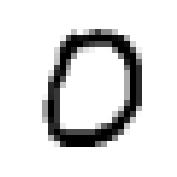

In [5]:
il[0].show()

In [6]:
sd = il.split_by_folder(train='training', valid='testing')   # 拆分训练集和验证集。如果不需要验证集，就可以使用.no_split()方法创建空的验证集
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\caoyanjie\.fastai\data\mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\caoyanjie\.fastai\data\mnist_png;

Test: None

In [7]:
(path/'training').ls()

[WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/0'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/1'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/2'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/3'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/4'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/5'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/6'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/7'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/8'),
 WindowsPath('C:/Users/caoyanjie/.fastai/data/mnist_png/training/9')]

In [8]:
ll = sd.label_from_folder()
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\caoyanjie\.fastai\data\mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\caoyanjie\.fastai\data\mnist_png;

Test: None

0 torch.Size([1, 28, 28])


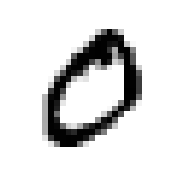

In [9]:
x, y = ll.train[0]
x.show()
print(y, x.shape)

0


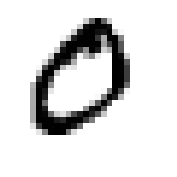

In [10]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])    # 添加变换，这里不使用常见的get_transform()函数，因为数字不应该左右翻转，rand_pad:随机填充 填充和随机裁剪，[]是验证集的变换
ll = ll.transform(tfms)
bs = 128
data = ll.databunch(bs=bs).normalize()                        # 这里不适用预训练模型，所以不用imagenet_stats
x, y = data.train_ds[0]
x.show()
print(y)

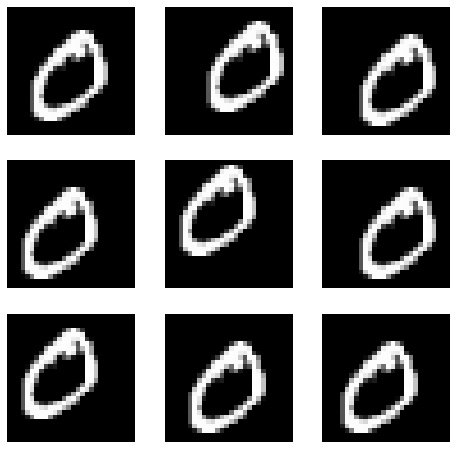

In [11]:
def _plot(i, j, ax):
    data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))    # 如果数字显示很多次，数字显示的位置都会有一些不同，因为对图片做了随机填充

In [12]:
xb, yb = data.one_batch()
xb.shape, yb.shape         # 批次数，通道数，行数，列数

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

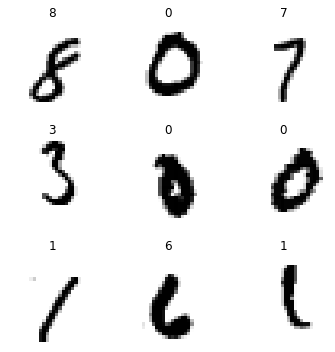

In [13]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [14]:
def conv(ni, nf):
    return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

model = nn.Sequential(
    conv(1, 8),
    nn.BatchNorm2d(8),   # 8x14x14
    nn.ReLU(),
    conv(8, 16),
    nn.BatchNorm2d(16),  # 16x7x7
    nn.ReLU(),
    conv(16, 32),
    nn.BatchNorm2d(32),  # 32x4x4
    nn.ReLU(),
    conv(32, 16),
    nn.BatchNorm2d(16),  # 16x2x2
    nn.ReLU(),
    conv(16, 10),
    nn.BatchNorm2d(10),  # 输出 10x1x1 的三阶张量
    Flatten()
)
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [15]:
xb = xb.cuda()
model(xb).shape

torch.Size([128, 10])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


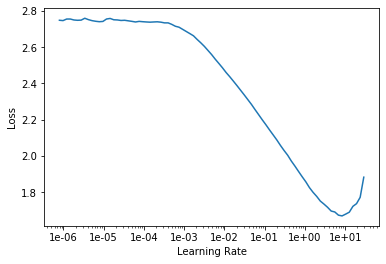

In [16]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.217213,0.434512,0.871900,00:58
1,0.133597,0.103040,0.966600,00:58
2,0.075262,0.039481,0.987800,00:58


### Refactor  做一点点小的重构

In [18]:
def conv2(ni, nf):
    return conv_layer(ni, nf, stride=2)

model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()
)

learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.238035,0.417746,0.878900,00:57
1,0.190250,0.229319,0.928600,00:57
2,0.171099,0.195471,0.938900,00:56
3,0.138926,0.162419,0.947800,00:57
4,0.120905,0.083337,0.972700,01:01
5,0.096014,0.095027,0.968600,00:59
6,0.087531,0.052016,0.983000,00:58
7,0.067713,0.039473,0.987700,01:00
8,0.051305,0.028219,0.991400,00:59
9,0.045612,0.026636,0.991700,01:00


## Resnet-ish

In [19]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
    
    def forward(self, x):
        return x + self.conv2(self.conv1(x))
# help(res_block)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


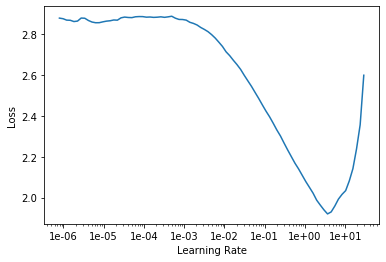

In [20]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8), 
    
    conv2(8, 16),
    res_block(16),
    
    conv2(16, 32),
    res_block(32), 
    
    conv2(32, 16),
    res_block(16),
    
    conv2(16, 10),
    Flatten()
)

def conv_and_res(ni, nf):
    return nn.Sequential(conv2(ni, nf), res_block(nf))

model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.192266,0.134266,0.962500,01:10
1,0.131670,0.130746,0.961500,01:08
2,0.105597,0.073545,0.975600,01:07
3,0.081945,0.060742,0.980300,01:07
4,0.063807,0.065511,0.978100,01:08
5,0.070150,0.044948,0.986000,01:09
6,0.045094,0.059551,0.979400,01:09
7,0.045892,0.031738,0.989300,01:09
8,0.032934,0.020325,0.993300,01:10
9,0.025395,0.017307,0.994600,01:08


In [22]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________